In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (davies_bouldin_score, calinski_harabasz_score, silhouette_score, adjusted_rand_score,
    adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score)
from utils import sankey_plot_with_labels

RANDOM_STATE = 42
RESULTS_FOLDER = 'results/'
DATA_PATH = 'data/GSE239626/MTX'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read_10x_mtx(
    DATA_PATH,
    var_names='gene_symbols',
    gex_only=False,
    cache=True)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 72317 × 36636
    var: 'gene_ids', 'feature_types'

In [3]:
adata = adata[:, adata.var['feature_types'] == 'Antibody Capture'] # select only antibody capture features
adata

View of AnnData object with n_obs × n_vars = 72317 × 35
    var: 'gene_ids', 'feature_types'

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning:

Received a view of an AnnData. Making a copy.

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:233: UserWarning:

Some cells have zero counts



In [5]:
adata.X.getnnz() # number of non-zero elements in the matrix

2013559

In [6]:
adata.X.getnnz() / (adata.X.shape[0]*adata.X.shape[1])

0.7955288126285264

In [7]:
adata.X.shape

(72317, 35)

In [8]:
np.mean(adata.X.toarray()), np.std(adata.X.toarray())

(3.2623765, 2.3239512)

In [9]:
adata.X.max(), adata.X.min()

(9.210441, 0.0)

In [10]:
# exclude 0 values, print the mean and std of the data
X_nnz = adata.X[adata.X > 0]
np.mean(X_nnz), np.std(X_nnz), np.min(X_nnz), np.max(X_nnz)

(4.10089, 1.8303623, 0.04472257, 9.210441)

In [11]:
def perturbate_data(X, random_seed, noise_level=1):
    ##np.random.seed(random_seed)
    #noise = np.random.randint(0, noise_level, size=X.shape)
    noise = np.random.normal(0, noise_level, size=X.shape)
    return np.clip(a=X+noise, a_min=0, a_max=None)

def upsample_with_replacement(X, random_seed, upsample_ratio=1.2):
    np.random.seed(random_seed)
    n_samples = int(X.shape[0] * upsample_ratio)
    idx = np.random.choice(X.shape[0], n_samples, replace=True)
    return X[idx], idx

def upsample_with_noise(X, random_seed, upsample_ratio=1.2, noise_level=3):
    X, idx = upsample_with_replacement(X, random_seed, upsample_ratio)
    return perturbate_data(X, random_seed, noise_level), idx

def downsample_with_replacement(X, random_seed, downsample_ratio=0.8):
    np.random.seed(random_seed)
    n_samples = int(X.shape[0] * downsample_ratio)
    idx = np.random.choice(X.shape[0], n_samples, replace=True)
    return X[idx], idx

def downsample_with_noise(X, random_seed, downsample_ratio=0.8, noise_level=3):
    X, idx = downsample_with_replacement(X, random_seed, downsample_ratio)
    return perturbate_data(X, random_seed, noise_level), idx

In [12]:
def leiden_clustering(adata, n_neighbors=10, pca_dim=5, resolution=0.5):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)

        sc.pp.neighbors(
            adata,
            n_neighbors=n_neighbors,
            n_pcs=pca_dim,
            knn=True,
            metric='euclidean',
            random_state=RANDOM_STATE
            )

        sc.tl.umap(
            adata,
            n_components=2, # number of dimensions of the UMAP embedding
            method='umap',
            random_state=RANDOM_STATE,
            )

        sc.tl.leiden(
            adata,
            resolution=resolution,
            directed=False, # undirect graph
            n_iterations=-1, # until convergence of the clustering
            flavor='leidenalg',
            random_state=RANDOM_STATE,
            )
    
    return adata.obs['leiden']

In [13]:
def evaluate_clustering(X, y):
    scores = {
        'davies_bouldin_score': davies_bouldin_score(X, y),
        'calinski_harabasz_score': calinski_harabasz_score(X, y),
        'silhouette_score': silhouette_score(X, y),
    }
    return scores

def evaluate_clustering_wrt_original_data_label(y, y_original):
    y_original = y_original[y.notna()]
    y = y[y.notna()]
    scores = {
        'adjusted_rand': adjusted_rand_score(y_original, y),
        'adjusted_mutual_info': adjusted_mutual_info_score(y_original, y),
        'homogeneity': homogeneity_score(y_original, y),
        'completeness': completeness_score(y_original, y),
        'v_measure': v_measure_score(y_original, y),
        'fowlkes_mallows': fowlkes_mallows_score(y_original, y),
    }
    return scores

In [14]:
labels_df = pd.DataFrame()

X = sc.AnnData(adata.X)

sc.tl.pca(
    X,
    svd_solver='arpack',
    n_comps=30,
    random_state=RANDOM_STATE
    )

labels_df['original'] = leiden_clustering(X)

In [15]:
clustering_metrics_df = pd.DataFrame(columns=['data', 'random_seed',
    'adjusted_rand', 'adjusted_mutual_info', 'homogeneity', 'completeness', 'v_measure', 'fowlkes_mallows'])

clustering_metrics_df = pd.concat([clustering_metrics_df, pd.DataFrame({
    'data': ['original'],
    'random_seed': np.nan,
    #**evaluate_clustering(X.toarray(), labels_df['original'])
    **evaluate_clustering_wrt_original_data_label(labels_df['original'], labels_df['original'])
})], ignore_index=True)

C:\Users\giuli\AppData\Local\Temp\ipykernel_29316\2718950431.py:4: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [16]:
clustering_metrics_df

,data,random_seed,adjusted_rand,adjusted_mutual_info,homogeneity,completeness,v_measure,fowlkes_mallows
0,original,NaN,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
def idx_to_str(idx):
    return [str(i) for i in idx]

def compute_pca_and_clustering(X, random_seed, data_name, idx, n_neighbors=10, pca_dim=5, resolution=0.5):
    adata = sc.AnnData(X)

    print(f'Computing PCA and clustering...')
    sc.tl.pca(
    adata,
    svd_solver='arpack',
    n_comps=30,
    random_state=RANDOM_STATE
    )

    print(f'Running Leiden clustering...')
    idx_str = idx_to_str(idx)
    labels_df.loc[idx_str, data_name] = leiden_clustering(adata, n_neighbors, pca_dim, resolution)

    print(f'Evaluating clustering... \n')
    return pd.DataFrame({
        'data': [data_name],
        'random_seed': random_seed,
        #**evaluate_clustering(X.toarray(), labels_df[data_name])
        **evaluate_clustering_wrt_original_data_label(labels_df[data_name], labels_df['original'])
    })

In [18]:
X = adata.X

n_repeats = 2
noise_levels = [0.1, 1, 2] # gaussina std dev

for i in range(n_repeats):
    print(f'Iteration {i} \n')
    random_seed = RANDOM_STATE*i

    for noise_level in noise_levels:
        print(f'Noise level {noise_level} \n')
        print('Performing clustering on perturbated data')

        X_perturbated = perturbate_data(X.toarray(), random_seed)
        idx = np.arange(X_perturbated.shape[0])
        clustering_metrics_df = pd.concat([clustering_metrics_df,
            compute_pca_and_clustering(X_perturbated, random_seed, 
            f'perturbated_noise{noise_level}_{i}', idx)], ignore_index=True)

        print('Performing clustering on upsampled perturbated data')
        X_upsampled_perturbated, idx = upsample_with_noise(X.toarray(), random_seed)
        clustering_metrics_df = pd.concat([clustering_metrics_df,
            compute_pca_and_clustering(X_upsampled_perturbated, random_seed, 
            f'upsampled_perturbated_noise{noise_level}_{i}', idx)], ignore_index=True)
        
        print('Performing clustering on downsampled perturbated data')
        X_downsampled_perturbated, idx = downsample_with_noise(X.toarray(), random_seed)
        clustering_metrics_df = pd.concat([clustering_metrics_df,
            compute_pca_and_clustering(X_downsampled_perturbated, random_seed, 
            f'downsampled_perturbated_noise{noise_level}_{i}', idx)], ignore_index=True)

    print('Performing clustering on upsampled data')
    X_upsampled, idx = upsample_with_replacement(X.toarray(), random_seed)
    clustering_metrics_df = pd.concat([clustering_metrics_df,
        compute_pca_and_clustering(X_upsampled, random_seed, f'upsampled_{i}', idx)], ignore_index=True)
    
    print('Performing clustering on downsampled data')
    X_downsampled, idx = downsample_with_replacement(X.toarray(), random_seed)
    clustering_metrics_df = pd.concat([clustering_metrics_df,
        compute_pca_and_clustering(X_downsampled, random_seed, f'downsampled_{i}', idx)], ignore_index=True)

Iteration 0 

Noise level 0.1 

Performing clustering on perturbated data


Computing PCA and clustering...
Running Leiden clustering...
Evaluating clustering... 

Performing clustering on upsampled perturbated data
Computing PCA and clustering...
Running Leiden clustering...
Evaluating clustering... 

Performing clustering on downsampled perturbated data
Computing PCA and clustering...
Running Leiden clustering...
Evaluating clustering... 

Noise level 1 

Performing clustering on perturbated data
Computing PCA and clustering...
Running Leiden clustering...
Evaluating clustering... 

Performing clustering on upsampled perturbated data
Computing PCA and clustering...
Running Leiden clustering...
Evaluating clustering... 

Performing clustering on downsampled perturbated data
Computing PCA and clustering...
Running Leiden clustering...
Evaluating clustering... 

Noise level 2 

Performing clustering on perturbated data
Computing PCA and clustering...
Running Leiden clustering...
Evaluating clustering... 

Performing clustering on upsampled perturbated data
Comp

In [19]:
labels_df.head()

,original,perturbated_noise0.1_0,upsampled_perturbated_noise0.1_0,downsampled_perturbated_noise0.1_0,perturbated_noise1_0,upsampled_perturbated_noise1_0,downsampled_perturbated_noise1_0,perturbated_noise2_0,upsampled_perturbated_noise2_0,downsampled_perturbated_noise2_0,...,upsampled_perturbated_noise0.1_1,downsampled_perturbated_noise0.1_1,perturbated_noise1_1,upsampled_perturbated_noise1_1,downsampled_perturbated_noise1_1,perturbated_noise2_1,upsampled_perturbated_noise2_1,downsampled_perturbated_noise2_1,upsampled_1,downsampled_1
0,4,1,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,NaN,NaN,3,NaN,NaN,3,NaN,NaN,NaN,NaN
1,0,0,2,1,2,2,1,2,2,1,...,1,0,0,1,0,0,1,0,0,1
2,4,1,2,1,9,2,1,9,2,1,...,1,2,0,1,2,0,1,2,1,3
3,2,2,3,NaN,2,3,NaN,2,3,NaN,...,1,NaN,0,1,NaN,0,1,NaN,7,NaN
4,4,0,1,0,13,1,0,13,1,0,...,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN


In [20]:
clustering_metrics_df

,data,random_seed,adjusted_rand,adjusted_mutual_info,homogeneity,completeness,v_measure,fowlkes_mallows
0,original,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,perturbated_noise0.1_0,0.0,0.063884,0.132502,0.141047,0.128495,0.134479,0.170322
2,upsampled_perturbated_noise0.1_0,0.0,0.000108,0.000059,0.000858,0.001289,0.001030,0.170883
3,downsampled_perturbated_noise0.1_0,0.0,0.000255,-0.000079,0.001202,0.001883,0.001467,0.170618
4,perturbated_noise1_0,0.0,0.094007,0.148930,0.159446,0.143907,0.151278,0.204392
5,upsampled_perturbated_noise1_0,0.0,0.000108,0.000059,0.000858,0.001289,0.001030,0.170883
6,downsampled_perturbated_noise1_0,0.0,0.000255,-0.000079,0.001202,0.001883,0.001467,0.170618
7,perturbated_noise2_0,0.0,0.094007,0.148930,0.159446,0.143907,0.151278,0.204392
8,upsampled_perturbated_noise2_0,0.0,0.000108,0.000059,0.000858,0.001289,0.001030,0.170883
9,downsampled_perturbated_noise2_0,0.0,0.000255,-0.000079,0.001202,0.001883,0.001467,0.170618


In [21]:
# save results
labels_df.to_csv(os.path.join(RESULTS_FOLDER, 'labels_perturbated_data.csv'))
clustering_metrics_df.to_csv(os.path.join(RESULTS_FOLDER, 'clustering_metrics_perturbated_data.csv'))

### Results Explorations

In [22]:
labels_df = labels_df.astype(str)

In [40]:
columns_to_visualize_noise = [
    'perturbated_noise0.1_0', 'perturbated_noise1_0', 'perturbated_noise2_0', 'original',
    'perturbated_noise0.1_1', 'perturbated_noise1_1', 'perturbated_noise2_1']

columns_to_visualize_upsample = ['upsampled_perturbated_noise0.1_0', 'upsampled_perturbated_noise1_0',
    'upsampled_perturbated_noise2_0', 'original', 'upsampled_perturbated_noise0.1_1', 'upsampled_perturbated_noise1_1',
    'upsampled_perturbated_noise2_1']

columns_to_visualize_downsample = ['downsampled_perturbated_noise0.1_0', 'downsampled_perturbated_noise1_0',
    'downsampled_perturbated_noise2_0', 'original', 'downsampled_perturbated_noise0.1_1', 'downsampled_perturbated_noise1_1',
    'downsampled_perturbated_noise2_1']

In [44]:
sankey_plot_with_labels(
    labels=[labels_df[column] for column in columns_to_visualize_noise],
    labels_titles=['sigma 0.1', 'sigma 1', 'sigma 2', 'original', 'sigma 0.1', 'sigma 1', 'sigma 2'],
    title='Sankey diagram of the clustering results on perturbated data',
    width=1000,
    height=450
)

In [41]:
upsample_df = labels_df[(labels_df['upsampled_perturbated_noise0.1_0'] != 'nan') & 
    (labels_df['upsampled_perturbated_noise0.1_1'] != 'nan')][columns_to_visualize_upsample]

sankey_plot_with_labels(
    labels=[upsample_df[column] for column in columns_to_visualize_upsample],
    labels_titles=['sigma 0.1', 'sigma 1', 'sigma 2', 'original', 'sigma 0.1', 'sigma 1', 'sigma 2'],
    title='Sankey diagram of the clustering results on upsampled perturbated data',
    width=1000,
    height=450
)

In [43]:
dowsample_df = labels_df[(labels_df['downsampled_perturbated_noise0.1_0'] != 'nan') &
    (labels_df['downsampled_perturbated_noise0.1_1'] != 'nan')][columns_to_visualize_downsample]

sankey_plot_with_labels(
    labels=[dowsample_df[column] for column in columns_to_visualize_downsample],
    labels_titles=['sigma 0.1', 'sigma 1', 'sigma 2', 'original', 'sigma 0.1', 'sigma 1', 'sigma 2'],
    title='Sankey diagram of the clustering results on downsampled perturbated data',
    width=1000,
    height=450
)

In [45]:
# visualize the data distribution for each clusters in the original data compared to the perturbated data
def plot_cluster_distribution(ax, labels_df, data_name, title):
    for cluster in labels_df[data_name].unique():
        if cluster != 'nan':
            ax.bar(cluster, labels_df[data_name].value_counts()[cluster], label=cluster)
    ax.set_title(title, fontsize=6)

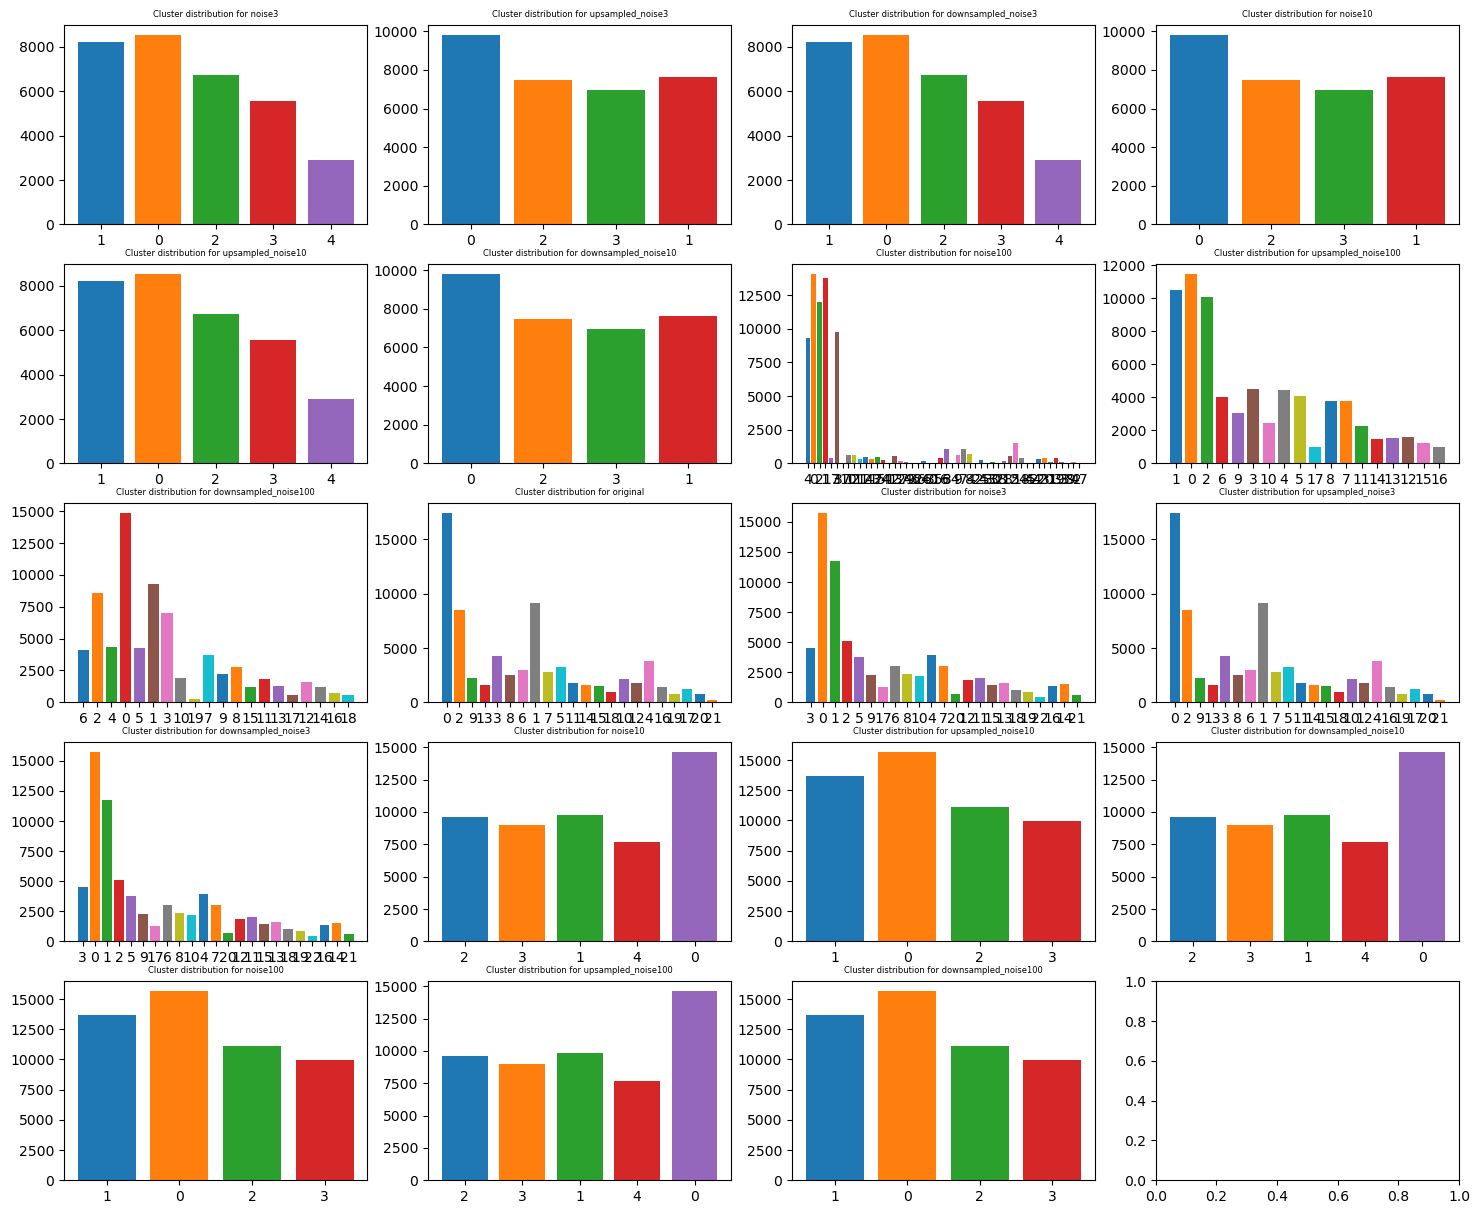

In [46]:
labels_titles=[
        'noise3', 'upsampled_noise3', 'downsampled_noise3',
        'noise10', 'upsampled_noise10', 'downsampled_noise10',
        'noise100', 'upsampled_noise100', 'downsampled_noise100',
        'original',
        'noise3', 'upsampled_noise3', 'downsampled_noise3',
        'noise10', 'upsampled_noise10', 'downsampled_noise10',
        'noise100', 'upsampled_noise100', 'downsampled_noise100']
columns_to_visualize = np.unique(columns_to_visualize_noise + columns_to_visualize_upsample + columns_to_visualize_downsample)

fig, axs = plt.subplots(5, 4, figsize=(18, 15))
for column in columns_to_visualize:
    idx = columns_to_visualize.tolist().index(column)
    ax = axs[idx//4, idx%4]
    plot_cluster_distribution(ax, labels_df, column, f'Cluster distribution for {labels_titles[idx]}')